In [ ]:
from google.colab import auth
auth.authenticate_user()

# Konfigurasi identitas GitHub
!git config --global user.email "satriadivop354@gmail.com"
!git config --global user.name "SatriaDivo"

# Clone repository dengan URL yang benar
!git clone https://@github.com/SatriaDivo/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran

# Masuk ke direktori repository
%cd Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran

Cloning into 'Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran'...
remote: Enumerating objects: 6221, done.
remote: Total 6221 (delta 0), reused 0 (delta 0), pack-reused 6221 (from 1)
Receiving objects: 100% (6221/6221), 110.03 MiB | 15.29 MiB/s, done.
/content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran


# **Step 1 — Preprocessing dan Split Data**

In [ ]:
# %%writefile step1_preprocess_split.py
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Path dataset asli dan hasil preprocessing
original_dataset = 'dataset'
preprocessed_dataset = 'preprocessed_dataset'
img_size = 224

# Cek kelas dan jumlah gambar per kelas
print("📦 Jumlah gambar per kelas:")
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"- {class_name}: {count} gambar")

# Buat struktur folder tujuan
for phase in ['train', 'val']:
    for class_name in os.listdir(original_dataset):
        os.makedirs(os.path.join(preprocessed_dataset, phase, class_name), exist_ok=True)

# Fungsi resize + pengecekan gambar
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Gagal membaca gambar: {image_path}")
        return None
    img = cv2.resize(img, (img_size, img_size))
    return img

# Proses split dan simpan
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    train_imgs, val_imgs = train_test_split(image_paths, test_size=0.3, random_state=42)

    for phase, img_list in zip(['train', 'val'], [train_imgs, val_imgs]):
        for img_path in tqdm(img_list, desc=f"{phase} - {class_name}"):
            img = preprocess_image(img_path)
            if img is not None:
                save_path = os.path.join(preprocessed_dataset, phase, class_name, os.path.basename(img_path))
                cv2.imwrite(save_path, img)

print("✅ Preprocessing & split selesai. Dataset disimpan di folder:", preprocessed_dataset)

📦 Jumlah gambar per kelas:
- Pepper__bell___healthy: 1478 gambar
- Pepper__bell___Bacterial_spot: 997 gambar
- Potato___Early_blight: 1000 gambar
- Potato___healthy: 152 gambar
- Tomato_Early_blight: 1000 gambar
- Tomato_healthy: 1591 gambar


val - Tomato_healthy: 100%|██████████| 478/478 [00:00<00:00, 820.46it/s]

✅ Preprocessing & split selesai. Dataset disimpan di folder: preprocessed_dataset


# **Step 2 — Membuat File Konfigurasi .yaml**

In [ ]:
# %%writefile step2_make_config.py
import os

preprocessed_dataset_path = 'preprocessed_dataset'
train_dir = os.path.join(preprocessed_dataset_path, 'train')
val_dir = os.path.join(preprocessed_dataset_path, 'val')
config_file_name = 'plant_disease_config.yaml'
config_file_path = os.path.join(preprocessed_dataset_path, config_file_name)

abs_train_path = os.path.abspath(train_dir)
abs_val_path = os.path.abspath(val_dir)

# Ambil daftar kelas
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# Validasi kelas
if not class_names:
    raise ValueError("❌ Tidak ditemukan kelas pada folder train!")

print(f"✅ Ditemukan {len(class_names)} kelas: {class_names}")

# Tulis file YAML
with open(config_file_path, 'w') as f:
    f.write(f"train: {abs_train_path}\n")
    f.write(f"val: {abs_val_path}\n")
    f.write("names:\n")
    for name in class_names:
        f.write(f"- {name}\n")

print(f"✅ File konfigurasi YOLOv8 berhasil dibuat: {config_file_path}")

✅ Ditemukan 6 kelas: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_healthy']
✅ File konfigurasi YOLOv8 berhasil dibuat: preprocessed_dataset/plant_disease_config.yaml


# **Step 3 — Pelatihan Model**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# %%writefile step3_train_model.py
from ultralytics import YOLO
import os

model = YOLO('yolov8m-cls.pt')

# Path to the directory containing the dataset config file
dataset_root_dir = os.path.abspath('preprocessed_dataset')
print("✅ Path ke root dataset:", dataset_root_dir)

output_name = "klasifikasi_daun"

model.train(
    data=dataset_root_dir,
    epochs=50,
    imgsz=224,
    batch=32,
    name=output_name,
    augment=True,
)

print(f"✅ Training selesai! Model tersimpan di: runs/classify/{output_name}/weights/best.pt")

100%|██████████| 32.7M/32.7M [00:01<00:00, 27.7MB/s]

✅ Path ke root dataset: /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/preprocessed_dataset
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/preprocessed_dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train

  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   2655744  ultralytics.nn.modules.conv.Conv             [384, 768, 3, 2]              
  8                  -1  2   7084032  ultralytics.nn.modules.block.C2f             [768, 768, 2, True]           
  9                  -1  1    993286  ultralytics.nn.modules.head.Classify         [768, 6]                      
YOLOv8m-cls summary: 80 layers, 15,780,022 parameters, 15,780,022 gradients, 41.9 GFLOPs
Transferred 228/230 items from pretrained weights
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 89.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1068.5±386.1 MB/s, size: 28.1 KB)


train: Scanning /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/preprocessed_dataset/train... 4350 images, 0 corrupt: 100%|██████████| 4350/4350 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 403.7±269.6 MB/s, size: 27.1 KB)


val: Scanning /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/preprocessed_dataset/val... 1868 images, 0 corrupt: 100%|██████████| 1868/1868 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/classify/klasifikasi_daun
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 49.08it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 55.67it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 50.29it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 52.65it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 55.81it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 57.31it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 48.82it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 53.72it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 58.31it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      1.77G     0.0258         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 56.94it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      1.77G    0.02381         30        224: 100%|██████████| 136/136 [00:06<00:00, 22.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 51.16it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      1.77G    0.02777         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 52.06it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      1.77G    0.02409         30        224: 100%|██████████| 136/136 [00:06<00:00, 22.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 55.04it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      1.84G     0.0368         30        224: 100%|██████████| 136/136 [00:06<00:00, 20.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 50.63it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      1.84G    0.02547         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 48.84it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      1.84G    0.03347         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 53.92it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      1.84G    0.02521         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 52.71it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      1.84G    0.01912         30        224: 100%|██████████| 136/136 [00:06<00:00, 22.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 53.39it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      1.84G    0.01418         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 54.76it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      1.84G    0.01323         30        224: 100%|██████████| 136/136 [00:06<00:00, 20.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 52.87it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      1.84G    0.01292         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 52.88it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      1.84G    0.01698         30        224: 100%|██████████| 136/136 [00:06<00:00, 22.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 51.61it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      1.84G    0.01566         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 51.91it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      1.84G    0.01664         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 54.69it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      1.84G    0.01577         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 48.70it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      1.84G    0.02007         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 48.59it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      1.84G    0.01547         30        224: 100%|██████████| 136/136 [00:06<00:00, 22.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 51.98it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      1.84G    0.01274         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 53.01it/s]


                   all      0.998          1

      Epoch    GPU_mem       loss  Instances       Size


      29/50      1.84G    0.01505         30        224: 100%|██████████| 136/136 [00:06<00:00, 22.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 50.19it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      1.84G    0.01068         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 53.86it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      1.84G   0.006917         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 56.35it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      1.84G   0.008759         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 53.48it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      1.84G   0.006369         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 54.04it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      1.84G   0.003867         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 51.56it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      1.84G   0.006432         30        224: 100%|██████████| 136/136 [00:06<00:00, 22.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 48.39it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      1.84G   0.007932         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 49.25it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      1.84G    0.00485         30        224: 100%|██████████| 136/136 [00:06<00:00, 22.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 51.29it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      1.84G   0.003404         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 54.51it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      1.84G   0.004407         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 49.35it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      1.84G   0.002816         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 55.34it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      1.84G   0.005275         30        224: 100%|██████████| 136/136 [00:06<00:00, 20.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 53.10it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      1.84G   0.004918         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 48.75it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      1.84G   0.002674         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 50.49it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      1.84G   0.004325         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 55.90it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      1.84G   0.002172         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 52.86it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      1.84G   0.002425         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 55.58it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      1.84G   0.003025         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 48.35it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      1.84G   0.001643         30        224: 100%|██████████| 136/136 [00:06<00:00, 22.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 53.00it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      1.84G   0.001719         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 53.52it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      1.84G   0.002922         30        224: 100%|██████████| 136/136 [00:06<00:00, 21.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 49.09it/s]

                   all      0.999          1



50 epochs completed in 0.104 hours.
Optimizer stripped from runs/classify/klasifikasi_daun/weights/last.pt, 31.7MB
Optimizer stripped from runs/classify/klasifikasi_daun/weights/best.pt, 31.7MB

Validating runs/classify/klasifikasi_daun/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8m-cls summary (fused): 42 layers, 15,770,342 parameters, 0 gradients, 41.6 GFLOPs
train: /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/preprocessed_dataset/train... found 4350 images in 6 classes ✅ 
val: /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/preprocessed_dataset/val... found 1868 images in 6 classes ✅ 
test: None...


               classes   top1_acc   top5_acc:   0%|          | 0/30 [00:00<?, ?it/s]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  13%|█▎        | 4/30 [00:00<00:01, 24.39it/s]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  23%|██▎       | 7/30 [00:00<00:01, 15.36it/s]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  50%|█████     | 15/30 [00:00<00:00, 32.07it/s]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  73%|███████▎  | 22/30 [00:00<00:00, 40.71it/s]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  90%|█████████ | 27/30 [00:00<00:00, 42.86it/s]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc: 100%|██████████| 30/30 [00:00<00:00, 36.88it/s]


                   all      0.999          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/klasifikasi_daun
✅ Training selesai! Model tersimpan di: runs/classify/klasifikasi_daun/weights/best.pt


# **Step 4 — Evaluasi Model**


🔍 Evaluating model: runs/classify/klasifikasi_daun/weights/best.pt
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8m-cls summary (fused): 42 layers, 15,770,342 parameters, 0 gradients, 41.6 GFLOPs
train: /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/preprocessed_dataset/train... found 4350 images in 6 classes ✅ 
val: /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/preprocessed_dataset/val... found 1868 images in 6 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1189.0±425.5 MB/s, size: 27.1 KB)


val: Scanning /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/preprocessed_dataset/val... 1868 images, 0 corrupt: 100%|██████████| 1868/1868 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 117/117 [00:01<00:00, 68.17it/s]


                   all      0.999          1
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val

📊 Evaluasi:
- Top-1 Accuracy : 0.9995
- Top-5 Accuracy : 1.0000
- Fitness Score  : 0.9997
- Dataset Path   : runs/classify/val



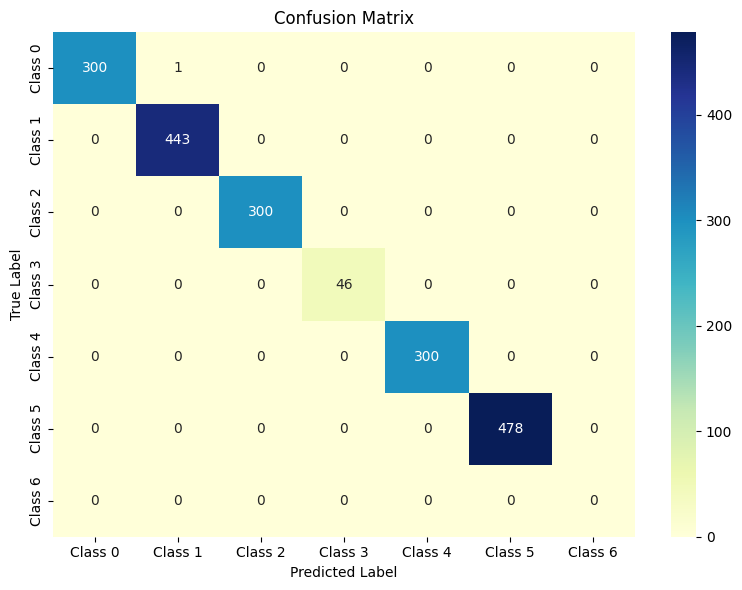

/tmp/ipython-input-25-607443344.py:49: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.where(total != 0, correct / total, 0)
/tmp/ipython-input-25-607443344.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=class_accuracy * 100, palette='crest')


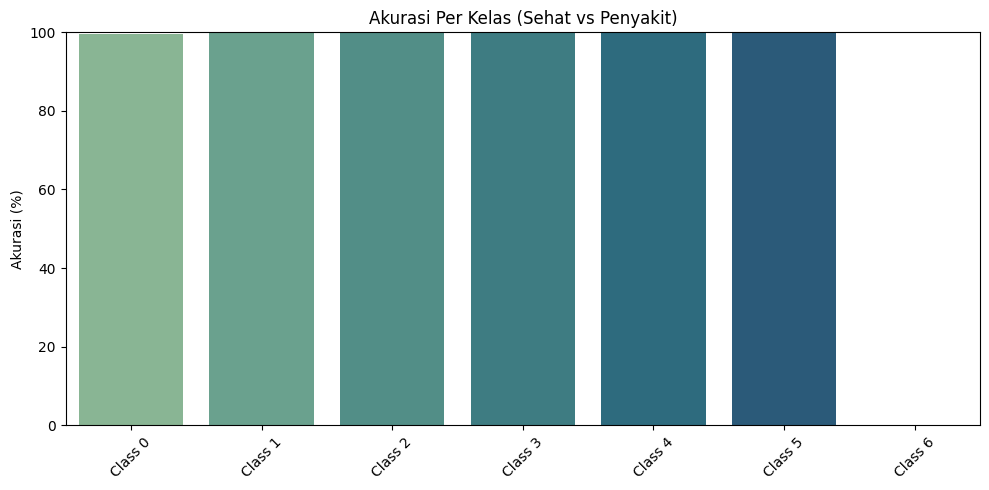

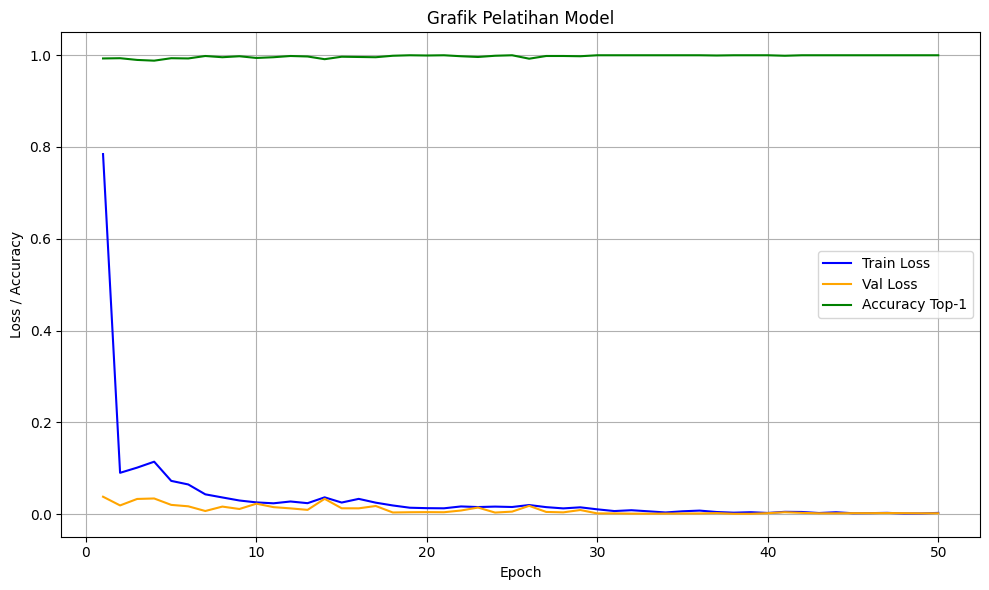

In [25]:
# %%writefile step4_evaluate.py
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from PIL import Image
import pandas as pd

# ------------------------------
# 🔍 Load model dan evaluasi
# ------------------------------
model_path = 'runs/classify/klasifikasi_daun/weights/best.pt'
model = YOLO(model_path)

print(f"\n🔍 Evaluating model: {model_path}")
results = model.val()

# ------------------------------
# 📊 Ringkasan hasil evaluasi
# ------------------------------
print("\n📊 Evaluasi:")
print(f"- Top-1 Accuracy : {results.top1:.4f}")
print(f"- Top-5 Accuracy : {results.top5:.4f}")
print(f"- Fitness Score  : {results.fitness:.4f}")
print(f"- Dataset Path   : {results.save_dir}\n")

# ------------------------------
# 📌 Confusion Matrix
# ------------------------------
if hasattr(results, 'confusion_matrix') and results.confusion_matrix is not None:
    cm = results.confusion_matrix.matrix.astype(int)
    labels = results.names if hasattr(results, 'names') else [f"Class {i}" for i in range(len(cm))]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='YlGnBu',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # --------------------------------------
    # 📌 Bar Chart Akurasi Per Kelas
    # --------------------------------------
    correct = np.diag(cm)
    total = cm.sum(axis=1)
    class_accuracy = np.where(total != 0, correct / total, 0)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels, y=class_accuracy * 100, palette='crest')
    plt.ylabel("Akurasi (%)")
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.title("Akurasi Per Kelas (Sehat vs Penyakit)")
    plt.tight_layout()
    plt.show()

# ------------------------------
# 📈 Grafik Pelatihan (Loss & Akurasi)
# ------------------------------
train_log_path = "runs/classify/klasifikasi_daun/results.csv"
if os.path.exists(train_log_path):
    df = pd.read_csv(train_log_path)
    df.columns = df.columns.str.strip()

    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['train/loss'], label='Train Loss', color='blue')
    plt.plot(df['epoch'], df['val/loss'], label='Val Loss', color='orange')
    plt.plot(df['epoch'], df['metrics/accuracy_top1'], label='Accuracy Top-1', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Loss / Accuracy")
    plt.title("Grafik Pelatihan Model")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ File log pelatihan (results.csv) tidak ditemukan.")

# **Step 5 – Evaluasi**

In [ ]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 116.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


🔎 Hasil prediksi YOLOv8m-cls:

image 1/1 /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/Early-blight-potato.png: 224x224 Potato___Early_blight 1.00, Tomato_healthy 0.00, Pepper__bell___Bacterial_spot 0.00, Tomato_Early_blight 0.00, Potato___healthy 0.00, 5.0ms
Speed: 2.9ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
🖼️ Early-blight-potato.png → Prediksi: Potato___Early_blight, Confidence: 1.00

image 1/1 /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/early-blight-of-pepper.jpg: 224x224 Pepper__bell___Bacterial_spot 1.00, Pepper__bell___healthy 0.00, Potato___Early_blight 0.00, Tomato_Early_blight 0.00, Potato___healthy 0.00, 4.8ms
Speed: 3.4ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
🖼️ early-blight-of-pepper.jpg → Prediksi: Pepper__bell___Bacterial_spot, Confidence: 1.00

image 1/1 /content/Tugas-Akhir_Pemanfaatan-CNN-untuk-

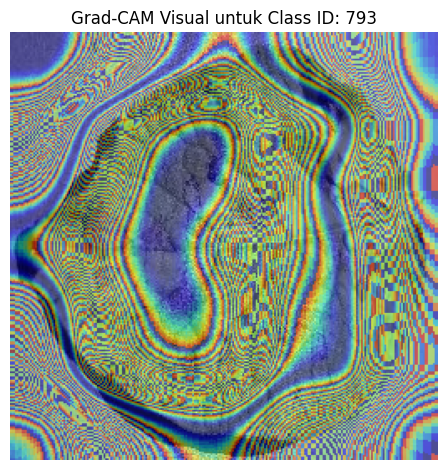

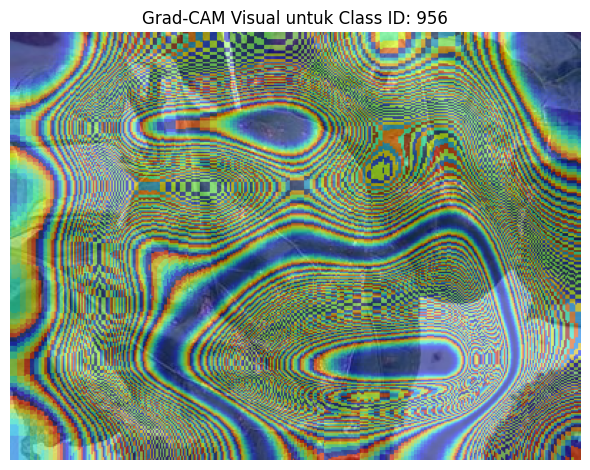

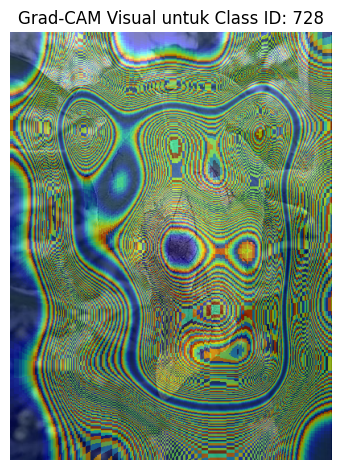

In [33]:
# %%writefile step5_inference_with_gradcam.py
from ultralytics import YOLO
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import torch

# 📌 Bagian 1: Inference dengan model YOLOv8m-cls
model_path = 'runs/classify/klasifikasi_daun/weights/best.pt'
model = YOLO(model_path)

# Daftar gambar uji (pastikan file ada di direktori)
image_paths = [
    'Early-blight-potato.png',
    'early-blight-of-pepper.jpg',
    'tomato-Early-Blight.png'
]

print("🔎 Hasil prediksi YOLOv8m-cls:")
for img_path in image_paths:
    if not os.path.exists(img_path):
        print(f"❌ File tidak ditemukan: {img_path}")
        continue

    result = model(img_path)
    probs = result[0].probs
    pred_label = result[0].names[probs.top1] if hasattr(result[0], 'names') else probs.top1
    print(f"🖼️ {img_path} → Prediksi: {pred_label}, Confidence: {probs.top1conf:.2f}")

# 📌 Bagian 2: Grad-CAM Visualisasi menggunakan ResNet18
print("\n📘 Grad-CAM Visualisasi menggunakan ResNet18 (proxy interpretasi)")

# Load model CNN proxy (pretrained)
cam_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
cam_model.eval()

# Aktifkan gradien pada semua layer agar CAM bisa berjalan
for param in cam_model.parameters():
    param.requires_grad_()

# Inisialisasi CAM extractor
cam_extractor = SmoothGradCAMpp(cam_model)

# Transformasi input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Proses tiap gambar
for img_path in image_paths:
    if not os.path.exists(img_path):
        continue

    img_pil = Image.open(img_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0)

    # Jangan gunakan torch.no_grad() agar CAM bisa bekerja
    output = cam_model(input_tensor)
    class_id = output.squeeze(0).argmax().item()

    # Ambil peta aktivasi dari CAM
    activation_map = cam_extractor(class_id, output)

    # Gabungkan heatmap dengan gambar asli
    # Konversi mask ke format gambar (PIL.Image)
    heatmap = activation_map[0].squeeze(0).cpu().numpy()
    heatmap = (heatmap * 255).astype(np.uint8)  # Skala ke 0–255
    heatmap_pil = Image.fromarray(heatmap).resize(img_pil.size).convert("L")

    # Overlay heatmap ke gambar asli
    result = overlay_mask(img_pil, heatmap_pil, alpha=0.5)

    # Tampilkan hasil
    plt.imshow(result)
    plt.title(f"Grad-CAM Visual untuk Class ID: {class_id}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [34]:
!git add .
!git commit -m "First Commit"
!git push origin main

Streaming output truncated to the last 5000 lines.
 create mode 100644 preprocessed_dataset/train/Pepper__bell___healthy/8e8ad705-85d5-407a-b439-1464cb166e34___JR_HL 7924.JPG
 create mode 100644 preprocessed_dataset/train/Pepper__bell___healthy/8eedd5d7-c85b-4f55-b7f8-48cfbd80f2f6___JR_HL 7674.JPG
 create mode 100644 preprocessed_dataset/train/Pepper__bell___healthy/8f22c1c0-6cbe-4fa3-9fe1-2752685622d1___JR_HL 7570.JPG
 create mode 100644 preprocessed_dataset/train/Pepper__bell___healthy/8fb8b9da-da17-44e5-8ce6-05c47cd356f4___JR_HL 8087.JPG
 create mode 100644 preprocessed_dataset/train/Pepper__bell___healthy/8fc0b784-cf68-4d0c-8634-1d51e9102c18___JR_HL 8823.JPG
 create mode 100644 preprocessed_dataset/train/Pepper__bell___healthy/8fc82b12-a4a6-4baa-8ba9-76db09c2915f___JR_HL 7876.JPG
 create mode 100644 preprocessed_dataset/train/Pepper__bell___healthy/8fef0301-cadf-46db-893e-3ae309faf40b___JR_HL 8050.JPG
 create mode 100644 preprocessed_dataset/train/Pepper__bell___healthy/9033b45d-67

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Vegetable-Disease.ipynb" "/content/Tugas-Akhir_Pemanfaatan-CNN-untuk-Identifikasi-Dini-Penyakit-pada-Daun-Sayuran/"